In [3]:
import pandas as pd
import numpy as np

data =  open('links.txt').read().splitlines()
PATH = 'data/'
data



['turnstile_160507.txt',
 'turnstile_160514.txt',
 'turnstile_160521.txt',
 'turnstile_160528.txt',
 'turnstile_160604.txt',
 'turnstile_160611.txt',
 'turnstile_160618.txt',
 'turnstile_160625.txt',
 'turnstile_160702.txt']

In [4]:
dfs = [pd.read_csv(PATH + path) for path in data]
df = pd.concat(dfs, ignore_index=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747984 entries, 0 to 1747983
Data columns (total 11 columns):
C/A                                                                     object
UNIT                                                                    object
SCP                                                                     object
STATION                                                                 object
LINENAME                                                                object
DIVISION                                                                object
DATE                                                                    object
TIME                                                                    object
DESC                                                                    object
ENTRIES                                                                 int64
EXITS                                                                   int64
dtypes: int64(2), ob

In [6]:
df.columns = df.columns.str.strip()

df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [7]:
df['DATETIME'] = pd.to_datetime(df.DATE + " " + df.TIME, format='%m/%d/%Y %H:%M:%S')
df.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456,BMT,04/30/2016,00:00:00,REGULAR,5639941,1909983,2016-04-30 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456,BMT,04/30/2016,04:00:00,REGULAR,5639991,1909993,2016-04-30 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456,BMT,04/30/2016,08:00:00,REGULAR,5640014,1910024,2016-04-30 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456,BMT,04/30/2016,12:00:00,REGULAR,5640158,1910134,2016-04-30 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456,BMT,04/30/2016,16:00:00,REGULAR,5640454,1910197,2016-04-30 16:00:00
5,A002,R051,02-00-00,59 ST,NQR456,BMT,04/30/2016,20:00:00,REGULAR,5640802,1910254,2016-04-30 20:00:00
6,A002,R051,02-00-00,59 ST,NQR456,BMT,05/01/2016,00:00:00,REGULAR,5640974,1910328,2016-05-01 00:00:00
7,A002,R051,02-00-00,59 ST,NQR456,BMT,05/01/2016,04:00:00,REGULAR,5640996,1910333,2016-05-01 04:00:00
8,A002,R051,02-00-00,59 ST,NQR456,BMT,05/01/2016,08:00:00,REGULAR,5641021,1910358,2016-05-01 08:00:00
9,A002,R051,02-00-00,59 ST,NQR456,BMT,05/01/2016,12:00:00,REGULAR,5641113,1910427,2016-05-01 12:00:00


In [8]:
# Make sure there are no duplicate entries
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATETIME"], inplace=True)

In [98]:
df[["PREV_DATETIME", "PREV_ENTRIES", "PREV_EXITS"]] = (df.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATETIME", "ENTRIES", "EXITS"]
                                            .transform(lambda grp: grp.shift(1)))
df.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,PREV_DATETIME,PREV_ENTRIES,ENTRY_COUNT,TIME_INTERVAL,WEEKDAY,PREV_EXITS
1,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,04:00:00,REGULAR,5639991,1909993,2016-04-30 04:00:00,NaT,NaN,50.0,4.0,5,NaN
2,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,08:00:00,REGULAR,5640014,1910024,2016-04-30 08:00:00,2016-04-30 04:00:00,5639991.0,23.0,4.0,5,1909993.0
3,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,12:00:00,REGULAR,5640158,1910134,2016-04-30 12:00:00,2016-04-30 08:00:00,5640014.0,144.0,4.0,5,1910024.0
4,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,16:00:00,REGULAR,5640454,1910197,2016-04-30 16:00:00,2016-04-30 12:00:00,5640158.0,296.0,4.0,5,1910134.0
5,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,20:00:00,REGULAR,5640802,1910254,2016-04-30 20:00:00,2016-04-30 16:00:00,5640454.0,348.0,4.0,5,1910197.0
6,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-05-01,00:00:00,REGULAR,5640974,1910328,2016-05-01 00:00:00,2016-04-30 20:00:00,5640802.0,172.0,4.0,6,1910254.0
7,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-05-01,04:00:00,REGULAR,5640996,1910333,2016-05-01 04:00:00,2016-05-01 00:00:00,5640974.0,22.0,4.0,6,1910328.0
8,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-05-01,08:00:00,REGULAR,5641021,1910358,2016-05-01 08:00:00,2016-05-01 04:00:00,5640996.0,25.0,4.0,6,1910333.0
9,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-05-01,12:00:00,REGULAR,5641113,1910427,2016-05-01 12:00:00,2016-05-01 08:00:00,5641021.0,92.0,4.0,6,1910358.0
10,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-05-01,16:00:00,REGULAR,5641329,1910508,2016-05-01 16:00:00,2016-05-01 12:00:00,5641113.0,216.0,4.0,6,1910427.0


In [99]:
df.dropna(subset=["PREV_DATETIME"], axis=0, inplace=True)
df.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,PREV_DATETIME,PREV_ENTRIES,ENTRY_COUNT,TIME_INTERVAL,WEEKDAY,PREV_EXITS
2,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,08:00:00,REGULAR,5640014,1910024,2016-04-30 08:00:00,2016-04-30 04:00:00,5639991.0,23.0,4.0,5,1909993.0
3,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,12:00:00,REGULAR,5640158,1910134,2016-04-30 12:00:00,2016-04-30 08:00:00,5640014.0,144.0,4.0,5,1910024.0
4,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,16:00:00,REGULAR,5640454,1910197,2016-04-30 16:00:00,2016-04-30 12:00:00,5640158.0,296.0,4.0,5,1910134.0
5,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,20:00:00,REGULAR,5640802,1910254,2016-04-30 20:00:00,2016-04-30 16:00:00,5640454.0,348.0,4.0,5,1910197.0
6,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-05-01,00:00:00,REGULAR,5640974,1910328,2016-05-01 00:00:00,2016-04-30 20:00:00,5640802.0,172.0,4.0,6,1910254.0


In [100]:
df['ENTRY_COUNT'] = df.ENTRIES - df.PREV_ENTRIES
df.ix[df.ENTRY_COUNT < 0, 'ENTRY_COUNT'] =  - df['ENTRY_COUNT']
df = df.drop(df[df.ENTRY_COUNT > 1000000].index)

In [102]:
df['EXIT_COUNT'] = df.EXITS - df.PREV_EXITS
df.ix[df.ENTRY_COUNT < 0, 'EXIT_COUNT'] =  - df['EXIT_COUNT']
df = df.drop(df[df.EXIT_COUNT > 1000000].index)
df.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,PREV_DATETIME,PREV_ENTRIES,ENTRY_COUNT,TIME_INTERVAL,WEEKDAY,PREV_EXITS,EXIT_COUNT
2,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,08:00:00,REGULAR,5640014,1910024,2016-04-30 08:00:00,2016-04-30 04:00:00,5639991.0,23.0,4.0,5,1909993.0,31.0
3,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,12:00:00,REGULAR,5640158,1910134,2016-04-30 12:00:00,2016-04-30 08:00:00,5640014.0,144.0,4.0,5,1910024.0,110.0
4,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,16:00:00,REGULAR,5640454,1910197,2016-04-30 16:00:00,2016-04-30 12:00:00,5640158.0,296.0,4.0,5,1910134.0,63.0
5,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,20:00:00,REGULAR,5640802,1910254,2016-04-30 20:00:00,2016-04-30 16:00:00,5640454.0,348.0,4.0,5,1910197.0,57.0
6,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-05-01,00:00:00,REGULAR,5640974,1910328,2016-05-01 00:00:00,2016-04-30 20:00:00,5640802.0,172.0,4.0,6,1910254.0,74.0
7,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-05-01,04:00:00,REGULAR,5640996,1910333,2016-05-01 04:00:00,2016-05-01 00:00:00,5640974.0,22.0,4.0,6,1910328.0,5.0
8,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-05-01,08:00:00,REGULAR,5641021,1910358,2016-05-01 08:00:00,2016-05-01 04:00:00,5640996.0,25.0,4.0,6,1910333.0,25.0
9,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-05-01,12:00:00,REGULAR,5641113,1910427,2016-05-01 12:00:00,2016-05-01 08:00:00,5641021.0,92.0,4.0,6,1910358.0,69.0
10,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-05-01,16:00:00,REGULAR,5641329,1910508,2016-05-01 16:00:00,2016-05-01 12:00:00,5641113.0,216.0,4.0,6,1910427.0,81.0
11,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-05-01,20:00:00,REGULAR,5641597,1910557,2016-05-01 20:00:00,2016-05-01 16:00:00,5641329.0,268.0,4.0,6,1910508.0,49.0


In [ ]:
def get_time_difference(row):
    time = pd.Timestamp(row['DATETIME']) - pd.Timestamp(row['PREV_DATETIME'])
    hours = int(time.seconds)//3600
    if hours != 4:
        return np.nan
    return hours

df['TIME_INTERVAL'] = df.apply(get_time_difference, axis=1)

In [ ]:
df.head(5)


In [61]:
# Remove time intervals that are not 4 hours
df.dropna(subset=["TIME_INTERVAL"], axis=0, inplace=True)

In [65]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
df['WEEKDAY'] = df['DATE'].dt.dayofweek
df.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,PREV_DATETIME,PREV_ENTRIES,ENTRY_COUNT,TIME_INTERVAL,WEEKDAY
1,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,04:00:00,REGULAR,5639991,1909993,2016-04-30 04:00:00,2016-04-30 00:00:00,5639941.0,50.0,4.0,5
2,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,08:00:00,REGULAR,5640014,1910024,2016-04-30 08:00:00,2016-04-30 04:00:00,5639991.0,23.0,4.0,5
3,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,12:00:00,REGULAR,5640158,1910134,2016-04-30 12:00:00,2016-04-30 08:00:00,5640014.0,144.0,4.0,5
4,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,16:00:00,REGULAR,5640454,1910197,2016-04-30 16:00:00,2016-04-30 12:00:00,5640158.0,296.0,4.0,5
5,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,20:00:00,REGULAR,5640802,1910254,2016-04-30 20:00:00,2016-04-30 16:00:00,5640454.0,348.0,4.0,5
6,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-05-01,00:00:00,REGULAR,5640974,1910328,2016-05-01 00:00:00,2016-04-30 20:00:00,5640802.0,172.0,4.0,6
7,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-05-01,04:00:00,REGULAR,5640996,1910333,2016-05-01 04:00:00,2016-05-01 00:00:00,5640974.0,22.0,4.0,6
8,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-05-01,08:00:00,REGULAR,5641021,1910358,2016-05-01 08:00:00,2016-05-01 04:00:00,5640996.0,25.0,4.0,6
9,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-05-01,12:00:00,REGULAR,5641113,1910427,2016-05-01 12:00:00,2016-05-01 08:00:00,5641021.0,92.0,4.0,6
10,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-05-01,16:00:00,REGULAR,5641329,1910508,2016-05-01 16:00:00,2016-05-01 12:00:00,5641113.0,216.0,4.0,6


In [89]:
df_weekday = df[df.WEEKDAY < 5]
df_weekend = df[df.WEEKDAY > 4]

df_weekend.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,PREV_DATETIME,PREV_ENTRIES,ENTRY_COUNT,TIME_INTERVAL,WEEKDAY
1,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,04:00:00,REGULAR,5639991,1909993,2016-04-30 04:00:00,2016-04-30 00:00:00,5639941.0,50.0,4.0,5
2,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,08:00:00,REGULAR,5640014,1910024,2016-04-30 08:00:00,2016-04-30 04:00:00,5639991.0,23.0,4.0,5
3,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,12:00:00,REGULAR,5640158,1910134,2016-04-30 12:00:00,2016-04-30 08:00:00,5640014.0,144.0,4.0,5
4,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,16:00:00,REGULAR,5640454,1910197,2016-04-30 16:00:00,2016-04-30 12:00:00,5640158.0,296.0,4.0,5
5,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,20:00:00,REGULAR,5640802,1910254,2016-04-30 20:00:00,2016-04-30 16:00:00,5640454.0,348.0,4.0,5


In [90]:
df_weekend['HOUR'] = pd.to_datetime(df['TIME'], format='%H:%M:%S').dt.hour
df_weekend.head(5)

/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,PREV_DATETIME,PREV_ENTRIES,ENTRY_COUNT,TIME_INTERVAL,WEEKDAY,HOUR
1,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,04:00:00,REGULAR,5639991,1909993,2016-04-30 04:00:00,2016-04-30 00:00:00,5639941.0,50.0,4.0,5,4
2,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,08:00:00,REGULAR,5640014,1910024,2016-04-30 08:00:00,2016-04-30 04:00:00,5639991.0,23.0,4.0,5,8
3,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,12:00:00,REGULAR,5640158,1910134,2016-04-30 12:00:00,2016-04-30 08:00:00,5640014.0,144.0,4.0,5,12
4,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,16:00:00,REGULAR,5640454,1910197,2016-04-30 16:00:00,2016-04-30 12:00:00,5640158.0,296.0,4.0,5,16
5,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-30,20:00:00,REGULAR,5640802,1910254,2016-04-30 20:00:00,2016-04-30 16:00:00,5640454.0,348.0,4.0,5,20


In [92]:
df_weekend = df_weekend.groupby(['STATION', 'LINENAME', 'WEEKDAY', 'HOUR'], as_index=False)['ENTRY_COUNT'].mean()
# sort by times
df_weekend = df_weekend[['STATION', 'LINENAME', 'WEEKDAY', 'HOUR', 'ENTRY_COUNT']]
df_weekend.head(5)
MORNING = 0 # 7 - 11 
AFTERNOON = 1 # 12 - 16
EVENING = 2 # 17 - 21
NIGHT = 3 # 22 - 2
MIDNIGHT = 3 - 6

df_weekend

,STATION,LINENAME,WEEKDAY,HOUR,ENTRY_COUNT
0,1 AV,L,5,0,510.142857
1,1 AV,L,5,4,189.011111
2,1 AV,L,5,8,69.877778
3,1 AV,L,5,12,286.055556
4,1 AV,L,5,16,497.337500


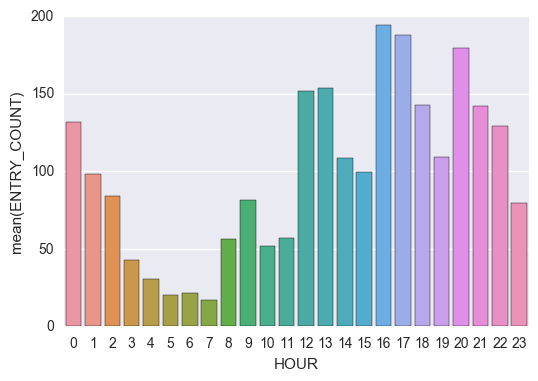

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline
import seaborn as sns

df_weekend_top_times = df_weekend.groupby('HOUR',as_index=False)['ENTRY_COUNT'].mean()
sns.barplot(x='HOUR', y='ENTRY_COUNT', data=df_weekend_top_times)